# Component z-density of CaCO3 Interfaces with Water

Author: Alec Glisman  
Date: 2024-02-02

## Imports

In [1]:
%matplotlib widget


In [2]:
# standard library
from dataclasses import dataclass
import os
from pathlib import Path

# third-party
import colorcet as cc
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import sys
from tqdm.auto import tqdm

# local
dir_proj_base = Path().cwd().parents[2]
sys.path.insert(0, f"{dir_proj_base}/src")

from render.util import set_style  # noqa: E402


In [3]:
set_style()


## Load Data

### User Inputs

In [4]:
# parameters
verbose = True
data_path = Path().cwd().parent / "data-START_1000-STOP_20000-STEP_1"
fig_args = {"dpi": 600, "bbox_inches": "tight"}
fig_ext = "png"
dir_output = Path().cwd() / "../output/axial_density"

zmin = 0.1 # nm
zmax = 1.2 # nm

labels = [
    r"Neat",
    r"64 CaCl$_2$",
    r"64 CaCO$_3$",
    r"16 AA",
    r"16 An",
    r"16 VAl",
    r"16 VAc",
]


In [5]:
dir_fig = dir_output / "figures"
dir_dat = dir_output / "data"

dir_fig.mkdir(exist_ok=True, parents=True)
dir_dat.mkdir(exist_ok=True, parents=True)


### Classes and Functions

In [6]:
@dataclass(frozen=False, order=True)
class Sim:
    """
    Dataclass for a single simulation
    """
    name: str
    sampling: str
    label: str
    z_numden_osol: list[np.ndarray]
    z_numden_hsol: list[np.ndarray]
    z_numden_notsol: list[np.ndarray]
    z_numden_all: list[np.ndarray]
    z_numden_cal: list[np.ndarray] = None
    z_numden_pe: list[np.ndarray] = None
    z_surface_pos: float = 0.0


In [7]:
def load_simulations(data_path: Path, labels: list[str]) -> list[Sim]:
    """
    Load all simulations from a directory

    Parameters
    ----------
    data_path : Path
        Path to the directory containing the simulations
    labels : list[str]
        List of labels for each simulation
    
    Returns
    -------
    list[Sim]
        List of Sim objects
    
    Raises
    ------
    FileNotFoundError
        If the data_path does not exist
    """
    # verify path exists
    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} does not exist")

    # iterate over all files in the directory and load the data
    sims = []
    simulations = [x for x in data_path.iterdir() if x.is_dir()]

    # FIXME: remove this line
    simulations = simulations[:3]

    if verbose:
        print(f"Found {len(simulations)} simulations")

    # iterate over all simulation systems
    for i, simulation in tqdm(enumerate(simulations), desc="Simulations", dynamic_ncols=True):
        if verbose:
            print(f" - Processing {simulation.name}")

        # iterate over all sampling methods
        sampling_methods = [x for x in simulation.iterdir() if x.is_dir()]
        for sampling_method in sampling_methods:
            if verbose:
                print(f"   - Sampling: {sampling_method.name}")

            sim = Sim(
                name=simulation.name,
                sampling=sampling_method.name,
                label=labels[i],
                z_numden_osol=np.load(
                    sampling_method
                    / "mdanalysis_lineardensity/data/lineardensity_z_resname_SOL_and_name_OW.npz"
                ),
                z_numden_hsol=np.load(
                    sampling_method
                    / "mdanalysis_lineardensity/data/lineardensity_z_resname_SOL_and_name_HW1_HW2.npz"
                ),
                z_numden_notsol=np.load(
                    sampling_method
                    / "mdanalysis_lineardensity/data/lineardensity_z_not_resname_SOL.npz"
                ),
                z_numden_all=np.load(
                    sampling_method
                    / "mdanalysis_lineardensity/data/lineardensity_z_all.npz"
                ),
                z_numden_cal=np.load(
                    sampling_method
                    / "mdanalysis_lineardensity/data/lineardensity_z_resname_CA_and_name_CA.npz"
                ),
                z_numden_pe=None,
            )
            sims.append(sim)

    return sims


### Script

In [8]:
sims = load_simulations(data_path, labels)


Found 3 simulations


Simulations: 0it [00:00, ?it/s]

 - Processing 4.1.0-calcite-104surface-9nm_surface-10nm_vertical-0chain-PAcr-0mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
   - Sampling: md
 - Processing 4.2.0-calcite-104surface-9nm_surface-10nm_vertical-0chain-PAcr-0mer-0Crb-64Ca-0Na-128Cl-300K-1bar-NVT
   - Sampling: md
 - Processing 4.3.0-calcite-104surface-9nm_surface-10nm_vertical-0chain-PAcr-0mer-64Crb-64Ca-0Na-0Cl-300K-1bar-NVT
   - Sampling: md


In [9]:
def save_fig(
    data: dict[str, np.ndarray],
    fig: plt.Figure, 
    figname: str,
    dir_dat: Path,
    dir_fig: Path, 
    ext: str = "png",
    fig_args: dict[str, any] = {"dpi": 600, "bbox_inches": "tight"}
) -> None:
    """
    Save a figure to a directory

    Parameters
    ----------
    data : dict[str, np.ndarray]
        Dictionary of data to save
    fig : plt.Figure
        Figure to save
    figname : str
        Name of the figure
    dir_dat : Path
        Directory to save the data
    dir_fig : Path
        Directory to save the figure
    ext : str
        Extension of the figure
    fig_args : dict[str, any]
        Arguments to pass to fig.savefig()
    """
    # pad data with NaNs
    max_length = max([len(value) for value in data.values()])
    for key, value in data.items():
        data[key] = np.pad(value, (0, max_length - len(value)), mode="constant", constant_values=np.nan)

    # save the figure
    df = pd.DataFrame(data)
    df.to_csv(dir_dat / f"{figname}.csv", index=False)
    fig.savefig(dir_fig / f"{figname}.{fig_ext}", **fig_args)


## Find CaCO3 surface z-coordinate

### Find surface z-coordinate

In [10]:
# find surface z-coordinate as last major peak in the number density profile
for sim in sims:
    z_ca = sim.z_numden_cal["number_density"]
    z_pos = sim.z_numden_cal["hist_bin_centers"]

    maxima, _ = find_peaks(z_ca, height=0.1, distance=10)
    sim.z_surface_pos = z_pos[maxima[-1]]

    if verbose:
        print(f"Simulation: {sim.sampling} - {sim.label}")
        print(f" - Surface position [A]: {sim.z_surface_pos:.2f}")

# save data
tags, z_pos = [], []
for sim in sims:
    tags.append(sim.name + "_" + sim.sampling)
    z_pos.append(sim.z_surface_pos)
df = pd.DataFrame({"tag": tags, "z_surface_pos_ang": z_pos})
df.to_csv(dir_dat / "z_surface_pos.csv", index=False)


Simulation: md - Neat
 - Surface position [A]: 24.12
Simulation: md - 64 CaCl$_2$
 - Surface position [A]: 24.15
Simulation: md - 64 CaCO$_3$
 - Surface position [A]: 24.13


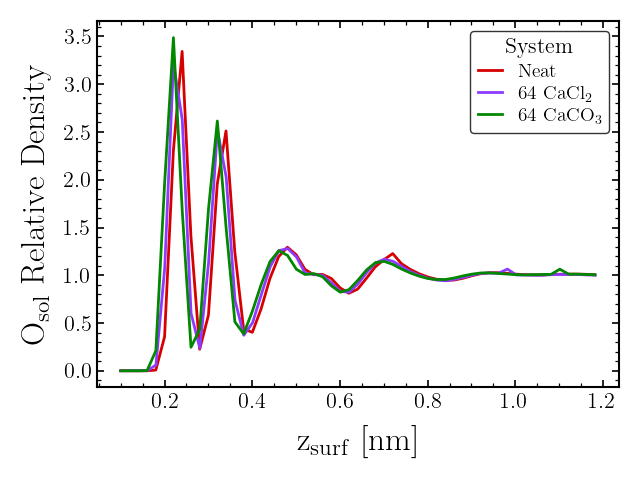

In [11]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "osol_density_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_osol["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_osol["number_density"] / np.average(sim.z_numden_osol["number_density"][-10:])
    idx_drop = np.where((x < zmin) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"O$_{\mathrm{sol}}$ Relative Density")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


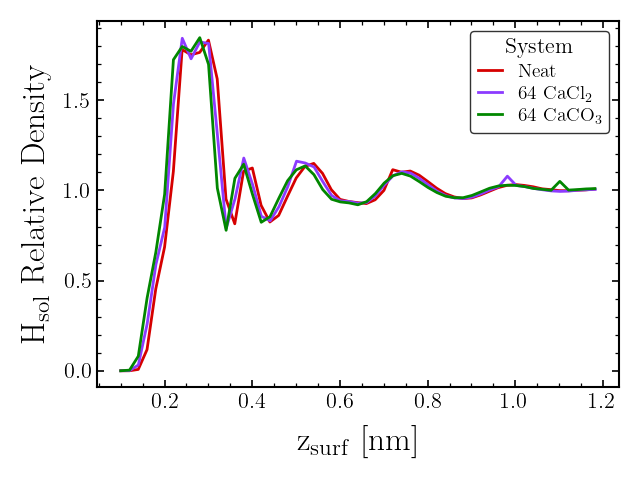

In [12]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "hsol_density_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_hsol["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_hsol["number_density"] / np.average(
        sim.z_numden_hsol["number_density"][-10:]
    )
    idx_drop = np.where((x < zmin) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"H$_{\mathrm{sol}}$ Relative Density")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

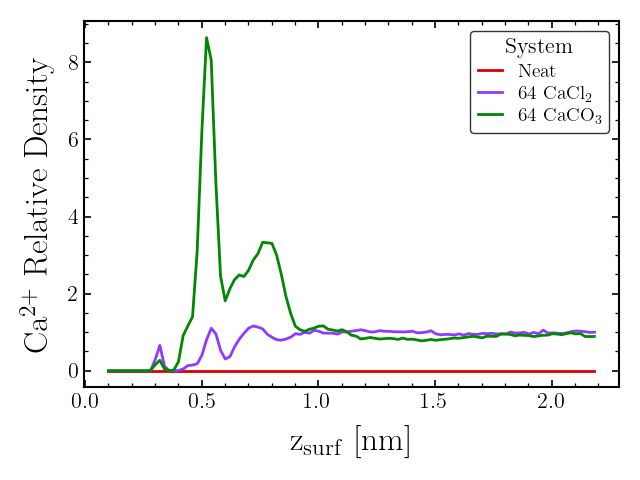

In [13]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "ca_density_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_cal["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_cal["number_density"] / 0.00017
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Ca$^{2+}$ Relative Density")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

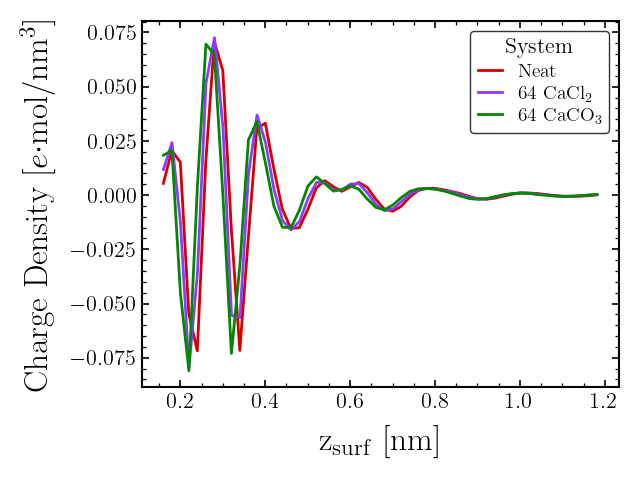

In [14]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "all_chargedensity_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_all["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_all["charge_density"] 
    idx_drop = np.where((x < 0.15) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Charge Density [$e$$\cdot$mol/nm$^3$]")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

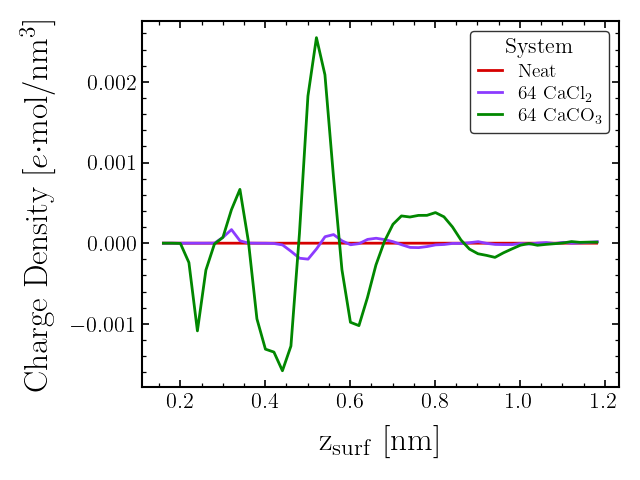

In [15]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "notsol_chargedensity_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_notsol["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_notsol["charge_density"]
    idx_drop = np.where((x < 0.15) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Charge Density [$e$$\cdot$mol/nm$^3$]")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()